In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Load data
df = pd.read_csv('motor_response_data.csv')

print("\n" + "="*60)
print("            DATA LOADED")
print("="*60)
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData info:")
print(df.info())
print("\nStatistics:")
print(df.describe())


TensorFlow version: 2.19.0
GPU Available: []

            DATA LOADED
Shape: (46, 4)
Columns: ['time', 'setpoint', 'speed', 'error']

First 5 rows:
           time  setpoint  speed  error
0  1.766131e+09         0      0      0
1  1.766131e+09         0      0      0
2  1.766131e+09         0      0      0
3  1.766131e+09       100      0    100
4  1.766131e+09       100    100      0

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      46 non-null     float64
 1   setpoint  46 non-null     int64  
 2   speed     46 non-null     int64  
 3   error     46 non-null     int64  
dtypes: float64(1), int64(3)
memory usage: 1.6 KB
None

Statistics:
               time    setpoint       speed       error
count  4.600000e+01   46.000000   46.000000   46.000000
mean   1.766131e+09  123.043478  123.043478    0.000000
std    6.726491e+00   86.457

In [ ]:
# Pilih features & target
X = df[['setpoint']].values  # Input: setpoint
y = df[['speed']].values     # Output: actual speed

print("="*60)
print("            PREPROCESSING")
print("="*60)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Normalize data (0-1)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create sequences untuk LSTM
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

print(f"\nSequence created:")
print(f"X_seq shape: {X_seq.shape}")  # (samples, time_steps, features)
print(f"y_seq shape: {y_seq.shape}")  # (samples, output)

# Split train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set:  {X_test.shape[0]} samples")
print("="*60)


            PREPROCESSING
X shape: (46, 1)
y shape: (46, 1)

Sequence created:
X_seq shape: (36, 10, 1)
y_seq shape: (36, 1)

Train set: 28 samples
Test set:  8 samples


In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(TIME_STEPS, 1)),
    Dropout(0.2),

    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dense(1)  # Output: predicted speed
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print("="*60)
print("            MODEL ARCHITECTURE")
print("="*60)
model.summary()


            MODEL ARCHITECTURE


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

print("\n" + "="*60)
print("            TRAINING START")
print("="*60)
print("Training with early stopping & learning rate reduction...")
print("This may take 2-5 minutes...\n")

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n" + "="*60)
print("            TRAINING COMPLETE!")
print("="*60)



            TRAINING START
Training with early stopping & learning rate reduction...
This may take 2-5 minutes...

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 552ms/step - loss: 0.4043 - mae: 0.5633 - val_loss: 0.3852 - val_mae: 0.4675 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.3816 - mae: 0.5459 - val_loss: 0.3609 - val_mae: 0.4578 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.3377 - mae: 0.5167 - val_loss: 0.3335 - val_mae: 0.4465 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.3024 - mae: 0.4848 - val_loss: 0.3030 - val_mae: 0.4325 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.2292 - mae: 0.4194 - val_loss: 0.2650 - val_mae: 0.4119 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2250 - mae: 0.4190 - val_loss: 0.2243 - val_mae: 0.3866 - learning_rate: 0.0010
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86m

In [ ]:
# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Inverse transform (kembali ke skala asli)
y_train_actual = scaler_y.inverse_transform(y_train)
y_pred_train_actual = scaler_y.inverse_transform(y_pred_train)

y_test_actual = scaler_y.inverse_transform(y_test)
y_pred_test_actual = scaler_y.inverse_transform(y_pred_test)

# Metrics
mae_train = mean_absolute_error(y_train_actual, y_pred_train_actual)
mae_test = mean_absolute_error(y_test_actual, y_pred_test_actual)

rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_pred_train_actual))
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_pred_test_actual))

r2_train = r2_score(y_train_actual, y_pred_train_actual)
r2_test = r2_score(y_test_actual, y_pred_test_actual)

print("="*60)
print("            MODEL EVALUATION")
print("="*60)
print("\nTRAIN METRICS:")
print(f"  MAE:  {mae_train:.3f}")
print(f"  RMSE: {rmse_train:.3f}")
print(f"  R²:   {r2_train:.4f}")

print("\nTEST METRICS:")
print(f"  MAE:  {mae_test:.3f}")
print(f"  RMSE: {rmse_test:.3f}")
print(f"  R²:   {r2_test:.4f}")
print("="*60)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
            MODEL EVALUATION

TRAIN METRICS:
  MAE:  23.380
  RMSE: 29.834
  R²:   0.8429

TEST METRICS:
  MAE:  25.882
  RMSE: 29.267
  R²:   0.9316


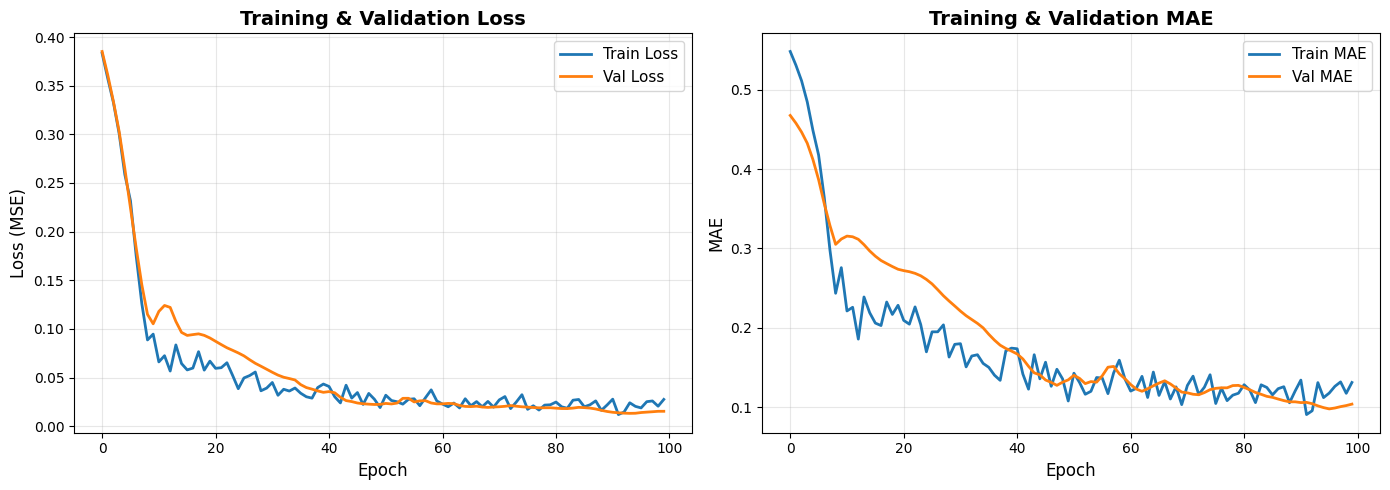

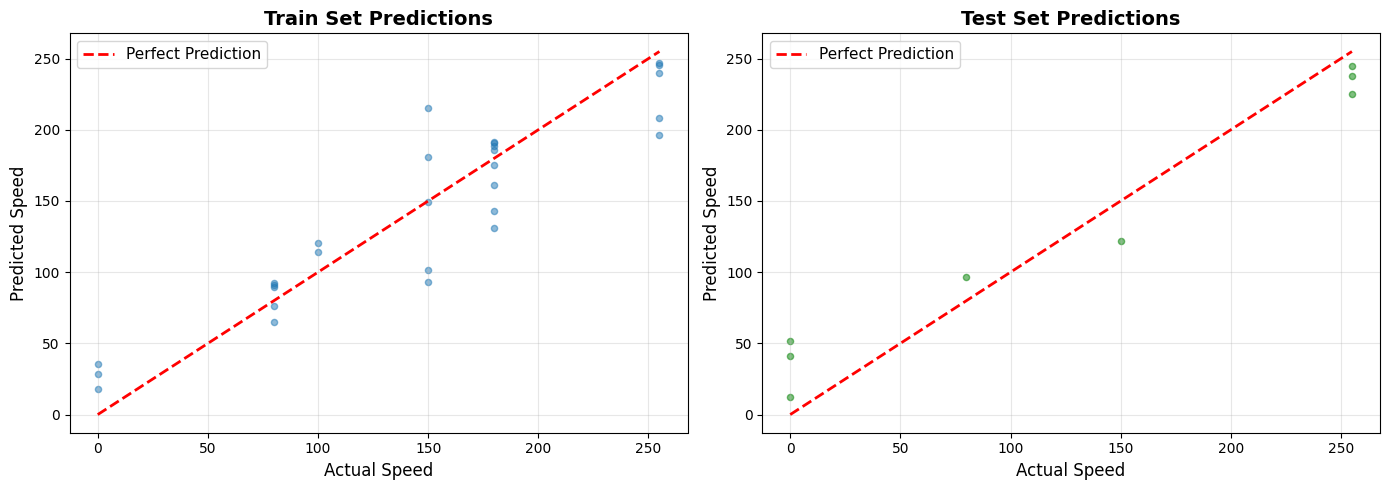

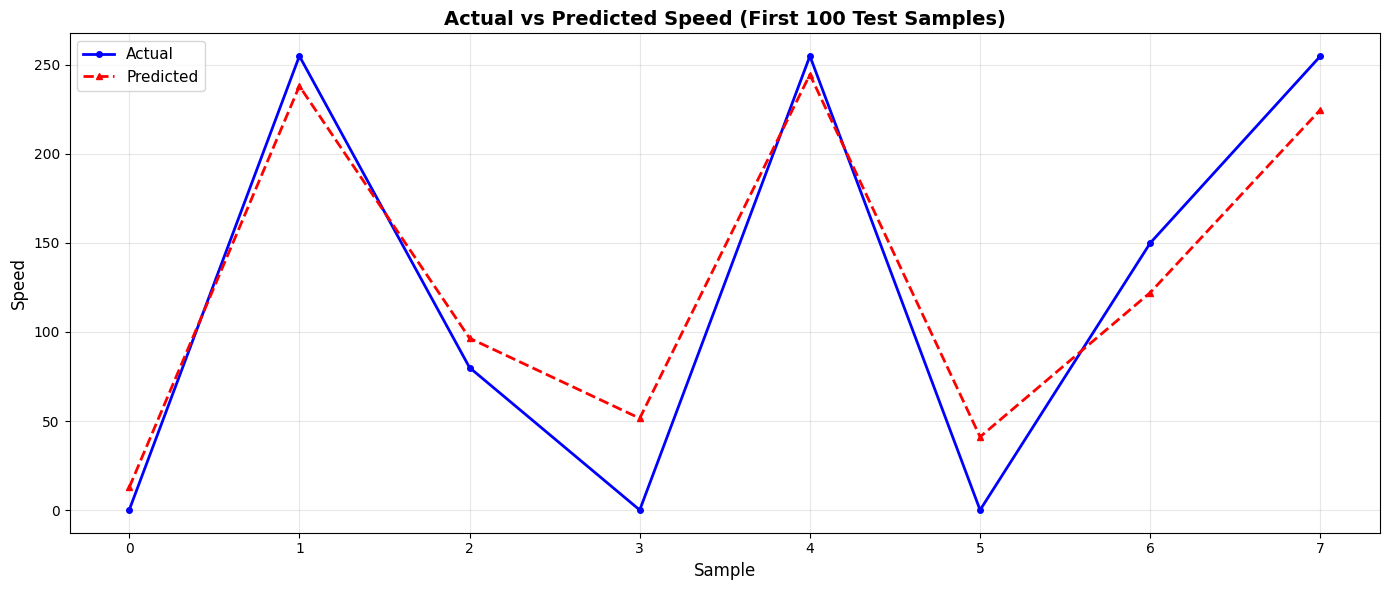


✓ All plots saved successfully!


In [ ]:
# Plot 1: Training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Training & Validation MAE', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot 2: Prediction vs Actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train set
axes[0].scatter(y_train_actual, y_pred_train_actual, alpha=0.5, s=20)
axes[0].plot([0, 255], [0, 255], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Speed', fontsize=12)
axes[0].set_ylabel('Predicted Speed', fontsize=12)
axes[0].set_title('Train Set Predictions', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test_actual, y_pred_test_actual, alpha=0.5, s=20, color='green')
axes[1].plot([0, 255], [0, 255], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Speed', fontsize=12)
axes[1].set_ylabel('Predicted Speed', fontsize=12)
axes[1].set_title('Test Set Predictions', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot 3: Time series comparison
plt.figure(figsize=(14, 6))
sample_size = min(100, len(y_test_actual))
plt.plot(y_test_actual[:sample_size], 'b-o', label='Actual', markersize=4, linewidth=2)
plt.plot(y_pred_test_actual[:sample_size], 'r--^', label='Predicted', markersize=4, linewidth=2)
plt.xlabel('Sample', fontsize=12)
plt.ylabel('Speed', fontsize=12)
plt.title('Actual vs Predicted Speed (First 100 Test Samples)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_time_series.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ All plots saved successfully!")


In [ ]:
# Save model
model.save('motor_lstm_model.h5')
print("✓ Model saved: motor_lstm_model.h5")

# Save scalers (untuk deployment nanti)
import pickle
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)
print("✓ Scalers saved")

print("\n" + "="*60)
print("   PROJECT 2 COMPLETE! 🎉")
print("="*60)
print("\nOutput files:")
print("  ✓ motor_lstm_model.h5")
print("  ✓ lstm_training_history.png")
print("  ✓ lstm_predictions.png")
print("  ✓ lstm_time_series.png")
print("  ✓ scaler_X.pkl, scaler_y.pkl")
print("="*60)


✓ Model saved: motor_lstm_model.h5
✓ Scalers saved

   PROJECT 2 COMPLETE! 🎉

Output files:
  ✓ motor_lstm_model.h5
  ✓ lstm_training_history.png
  ✓ lstm_predictions.png
  ✓ lstm_time_series.png
  ✓ scaler_X.pkl, scaler_y.pkl
